In [188]:
import csv
from unidecode import unidecode
latitude = []
longitude = []
city_name = []
county_name = []
city_population = []

with open('Datasets/ro.csv', newline='') as csvfile:
    DictReader = csv.DictReader(csvfile)
    ### Get latitude and longitude from csv
    for row in DictReader:
        city = unidecode(row['city'])
        city = city.replace("AY", 's')
        city = city.replace("APS", 't')
        city = city.replace("Af", 'a')
        city = city.replace("AC/", 'a')
        city_name = city_name + [city]
        county = unidecode(row['admin_name'])
        county = county.replace("AY", 's')
        county = county.replace("APS", 't')
        county = county.replace("Af", 'a')
        county = county.replace("AC/", 'a')
        county_name = county_name + [county]
        latitude = latitude + [row['lat']]
        longitude = longitude + [row['lng']]
        city_population = city_population + [row['population']]

## Set Cuda

In [189]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data about the hospitals in a given city

Cluj-Napoca,Cluj
Populatia 286598


C:\Users\Adrian\AppData\Local\Temp\ipykernel_16792\1810474921.py:12: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  hospitals = ox.geometries.geometries_from_place(location, tags={"amenity": "hospital", "amenity":"clinic", "healthcare":"hospital", "emergency":"yes"})


Pediatrie 2
Clinica de Chirurgie Maxilo-Facială
Policlinica Spital Salvosan Ciobanca
Clinica Interservișan
Regina Maria Centrul de Medicina Muncii
Dr Maghear Andrei Șfan
Spitalul Privat de Chirurgie
Terra med
Regina Maria - Punct de recoltare analize
Medicover
CosMedica
Hyperclinica MedLife
Cabinet de nefrologie și centru de dializă Fresenius
Clinica Bendis
Medical Cor
Radusan
Centrul medical gastroenterologie și hepatologie
Ronda Medical
QClinic
Institutul de Urologie
MS Care Dr. Sbirciu
Centrul Medical Raderm
Med Center
Novia Cosmetic Harmony Clinic
Affidea
Novogyn
Salina Saltera
Lavitamed
Synevo
NM Integrative Therapy
Centrul de Pediatrie
Regina Maria Policlinica Observatorului
Clinica Artis 3
Cardiomed
LaurusMedical
Asteco
Institutul roNEURO
Ortho Implant
Physio Medica
Clinica Napoca
Biogyn
Derma Elite
Synlab
Ares Cardiomed
Medicover
Regina Maria
Cuore
Telus Care
UroPoint
Clinica Duman
Union Medical
Rheumed Clinic
Regina Maria
MEDSTAR Policlinica Zorilor
Affidea
Centru Medical Anas

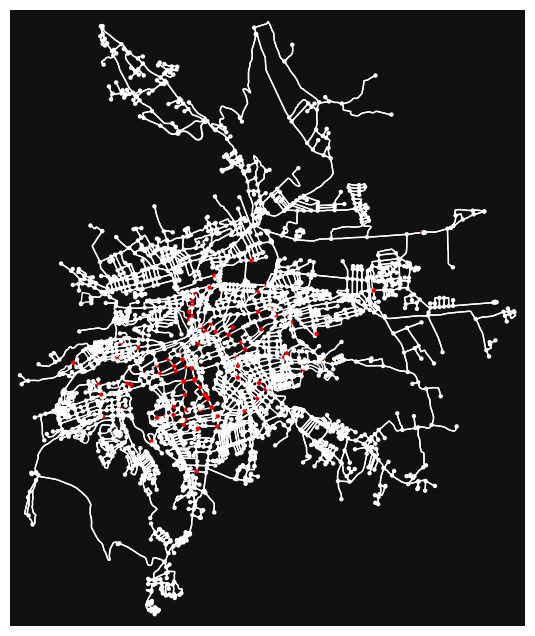

In [190]:
import networkx as nx
import geopandas as gpd
import osmnx as ox

location = city_name[1] + "," + county_name[1]
print(location)
print("Populatia", city_population[1])
# Get the street network graph
G = ox.graph_from_place(location, network_type="drive")

# Get the hospitals data
hospitals = ox.geometries.geometries_from_place(location, tags={"amenity": "hospital", "amenity":"clinic", "healthcare":"hospital", "emergency":"yes"})

# Create a new attribute for hospital nodes
for _, hospital in hospitals.iterrows():
    ## To get the hospital name I use  print(hospital['name'])

    print(hospital['name'])
    # Get the centroid of the hospital geometry
    centroid = hospital.geometry.centroid
    latitude, longitude = centroid.y, centroid.x
    
    # Find the nearest node in the street network graph to the hospital location
    nearest_node = ox.distance.nearest_nodes(G, longitude, latitude)
    
    # Add the hospital as a node to the graph
    G.add_node(nearest_node, type="hospital")

# Number of hospitals
print("Number of hospitals ", len(hospitals))
print("Number of streets ",  len(G))

# Set node colors based on their type
node_colors = ["red" if "type" in G.nodes[node] and G.nodes[node]["type"] == "hospital" else "white" for node in G.nodes()]
# Plot the graph with hospitals colored red and the rest with white
fig, ax = ox.plot_graph(G, node_color=node_colors, node_size=10, edge_color='w')

## GET BEDS/1000PEOPLE RATIO FOR EVERY CITY

In [196]:
import pandas as pd
import networkx as nx
import geopandas as gpd
import osmnx as ox

# Create empty lists to store data
city_names = []
populations = []
bed_counts_list = []
beds_population_ratios = []

for i in range(1, len(city_name)):
    try:
        location = city_name[i] + "," + county_name[i]
        population = city_population[i]
        # Get the hospitals data
        hospitals = ox.features.features_from_place(location, tags={"amenity": "hospital", "amenity":"clinic", "healthcare":"hospital", "emergency":"yes"})

        # Load the XLS file using pandas
        county_xls = "judetul-" + county_name[i].lower() + '.xls'
        xls_file_path = 'Datasets/HospitalsPerCounty/' + county_xls  # Replace with your actual file path

        with open(xls_file_path, 'rb') as file:
            xls = pd.ExcelFile(file)

            # Read the specific sheet
            df = pd.read_excel(file, sheet_name=xls.sheet_names[0], header=None)

        # Extract hospital names and bed counts
        hospital_names = []
        bed_counts = []

        for index, row in df.iterrows():
            if pd.notnull(row[1]) and row[1].startswith("U.SPIT."):
                hospital_name = row[1]
                if pd.notnull(row[2]):  # Check if beds information is in the same row
                    bed_counts.append(row[2])
                else:  # Beds information might be in the next row
                    bed_counts.append(df.iloc[index + 1, 2])
                    hospital_name += ' ' + str(df.iloc[index + 1, 1])  # Save the next row as part of the hospital name
                # Remove unwanted spaces in the hospital name
                hospital_name = ' '.join(hospital_name.split())

                # Replace special characters
                hospital_name = hospital_name.replace('Ț', 'T')
                hospital_name = hospital_name.replace('Ţ', 'T')
                hospital_name = hospital_name.replace('Ă', 'A')
                hospital_name = hospital_name.replace('Ș', 'S')
                hospital_name = hospital_name.replace('Ş', 'S')
                hospital_name = hospital_name.replace('Î', 'I')
                hospital_name = hospital_name.replace('Â', 'A')

                hospital_names.append(hospital_name)

        # Combine hospital names and bed counts
        combined_df = pd.DataFrame({'Hospital': hospital_names, 'Beds': bed_counts})

        number_of_beds = 0
        # Calculate total number of beds
        for index, row in combined_df.iterrows():
            if city_name[i].upper() in row['Hospital']:
                number_of_beds = number_of_beds + row['Beds']

        # Calculate beds per 1000 people
        beds_population_ratio = float(number_of_beds) * 1000 / float(population)

        # Store data in lists
        city_names.append(city_name[i])
        populations.append(population)
        bed_counts_list.append(number_of_beds)
        beds_population_ratios.append(beds_population_ratio)

    except Exception as e:
        print(f"Error processing {city_name[i]}: {e}")

# Create DataFrame from lists
data = {
    'city_name': city_names,
    'population': populations,
    'number_of_beds': bed_counts_list,
    'bed_population_ratio': beds_population_ratios
}
df = pd.DataFrame(data)

# Write DataFrame to CSV file
df.to_csv('Datasets\HospitalData\hospital_data.csv', index=False)

print("Data has been written to hospital_data.csv file.")


<>:86: DeprecationWarning: invalid escape sequence '\H'
<>:86: DeprecationWarning: invalid escape sequence '\H'
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16792\3309505294.py:86: DeprecationWarning: invalid escape sequence '\H'
  df.to_csv('Datasets\HospitalData\hospital_data.csv', index=False)


Error processing Deva: [Errno 2] No such file or directory: 'Datasets/HospitalsPerCounty/judetul-hunedoara.xls'
Error processing Hunedoara: [Errno 2] No such file or directory: 'Datasets/HospitalsPerCounty/judetul-hunedoara.xls'
Error processing Roman: No data elements in server response. Check log and query location/tags.
Error processing Voluntari: No data elements in server response. Check log and query location/tags.
Error processing Medgidia: No data elements in server response. Check log and query location/tags.
Error processing Petrosani: [Errno 2] No such file or directory: 'Datasets/HospitalsPerCounty/judetul-hunedoara.xls'
Data has been written to hospital_data.csv file.
